In [1]:
from utils import Args
from train import Training

### Training a Simple Model

In [2]:
args = Args()                                   # see Args object for default parameters
args.max_iter = 30
args.val_int = 25                               # compute validation loss every 25 grad steps

print("Default arguments : \n--------------------------\n", 
      args, '\n--------------------------')

train = Training(args)                          # training run takes a bag of parameters 
default_model, def_train_loss, def_valid_loss = train.train()

Default arguments : 
--------------------------
 Args(batch_size=10, n_tokens=64, n_layers=4, n_heads=4, d_model=128, use_lr_decay=True, lr=0.001, dataset_path='./datasets/shakespear_corpus.txt', max_iter=30, out_dir='./runs/', n_warm_iters=100, lr_decay_iter=5000, min_lr=0.0001, n_validation_batch=200, betas=(0.9, 0.99), n_epochs=10, val_int=25, save=True, save_int=200, name='milkshake', cross_val=False, k_fold=10) 
--------------------------
Epoch: 0, Batch index 0, Training Loss: 4.3084, Validation Loss: 4.3032
Epoch: 0, Batch index 25, Training Loss: 3.3023, Validation Loss: 3.4017


<All keys matched successfully>

In [3]:
from utils import generate

print(generate(default_model, train.tokenized_data, "POMPEY:", 150))

POMPEY:c?oat tstBsjnoY
A ra ssc!usoooa&uheSah 
t meI,wek;aJp,Coea. e Wih th MMwxenhBAslrHf n
 th :e
R. .vK &XrrreG, lkdn  o,,.?glae  
tlsi
  raoteao ael e jp


In [4]:
from utils import load_model_metrics, generate

long_model, long_model_params, long_train_loss, long_valid_loss = load_model_metrics(
    "./runs/long_model_b128_t256_l16_h16_d256_0_5000.pt",
    train.tokenized_data.vocabulary_size)

In [5]:
print(generate(long_model, train.tokenized_data, "Wherefore did they not", 100))

Wherefore did they not attend on the field.

TLRANIUS:
Hail, sir.

MARCIUS:
I have some daughter confused you wit him
Than


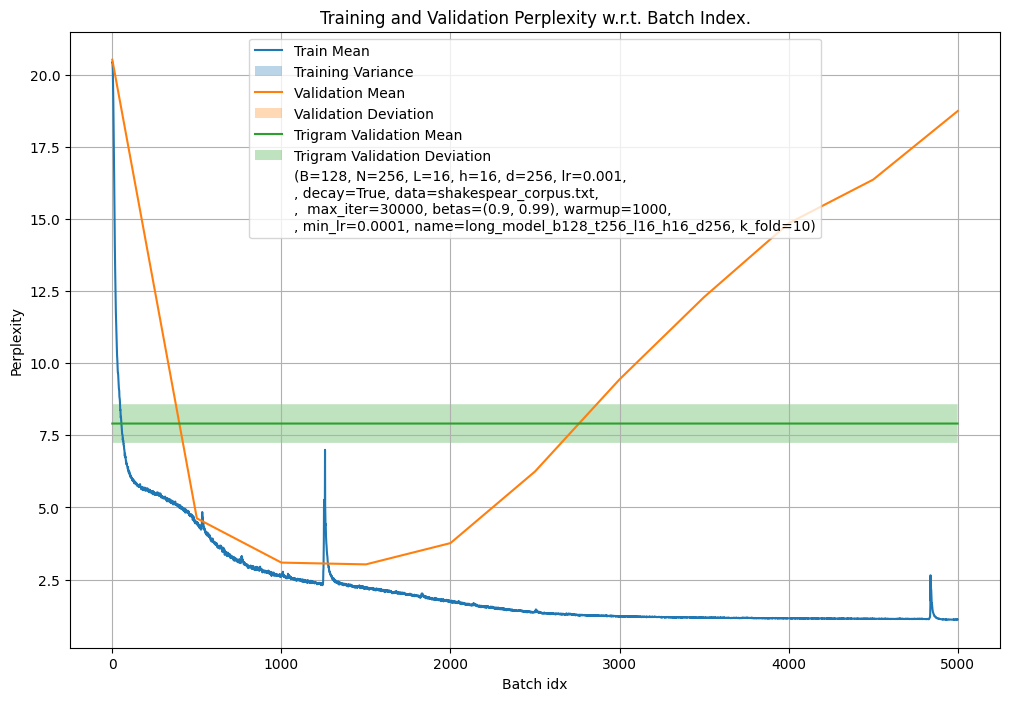

In [7]:
from utils import perplexity_graph

perplexity_graph(
    long_train_loss.unsqueeze(0), long_valid_loss.unsqueeze(0), 
    val_int=long_model_params['val_int'], name="long_model", args=long_model_params          
)

dict_keys(['k_fold_train_loss', 'k_fold_valid_loss', 'params'])


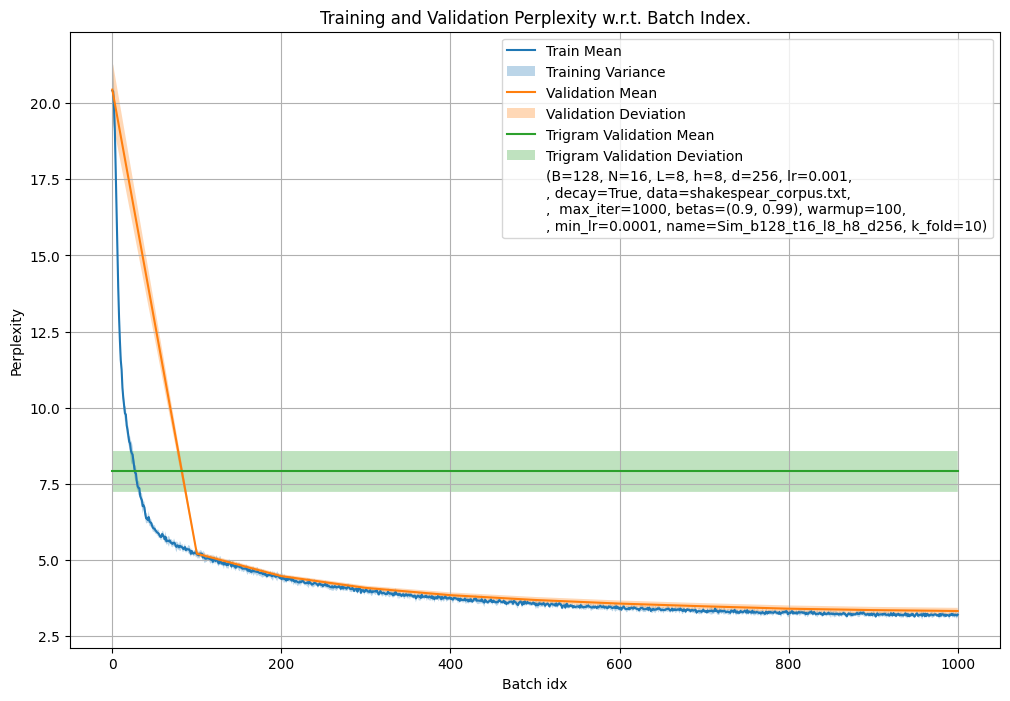

In [9]:
import torch
from utils import cv_losses_graph, perplexity_graph

# load cross validation recap file.
cross_val_run = torch.load(f'./simulation_results/Sim_b128_t16_l8_h8_d256/total_cross_val_metrics.pt')   
print(cross_val_run.keys())

perplexity_graph(
    cross_val_run ['k_fold_train_loss'], cross_val_run['k_fold_valid_loss'], 
    val_int=cross_val_run['params']['val_int'], name="Large window small model", 
    args=cross_val_run['params']          
)

In [ ]:
from N_gram import cross_val_ngram

perx_val_mean2, perx_val_std2 = cross_val_ngram(2, 10, './datasets/shakespear_corpus.txt', 128)
print("Bigram Perplexity Mean :", perx_val_mean2, "Perplexity std :", perx_val_std2)

perx_val_mean3, perx_val_std3 = cross_val_ngram(3, 10, './datasets/shakespear_corpus.txt', 128)
print("Trigram Perplexity Mean :", perx_val_mean3, "Perplexity std :", perx_val_std3)